In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
START_YEAR = 2020
END_YEAR = 2022

# ファイルの読み込み
df_train = pd.DataFrame()
for year in range(START_YEAR, END_YEAR+1):
    df = pd.read_csv(os.path.join(os.getcwd(),'data',f'temperature-{year}.csv'), encoding='shift-jis', skiprows=3)
    df.columns = ['datetime', 'temp']
    df['datetime'] = pd.to_datetime(df['datetime'])
    df_train = pd.concat([df_train, df])

# Indexの設定
df_train.index = pd.DatetimeIndex(df_train['datetime']).to_period('H')
df_train = df_train[['temp']]

# データの確認
print(f'N rows: {len(df_train)}')
print(df_train.index.min(), '-->', df_train.index.max())
print(f'NaN count: {df_train.isnull().sum().sum()}')
df_train.head()

N rows: 26304
2020-01-01 01:00 --> 2023-01-01 00:00
NaN count: 0


,temp
datetime,
2020-01-01 01:00,4.5
2020-01-01 02:00,4.1
2020-01-01 03:00,3.7
2020-01-01 04:00,3.2
2020-01-01 05:00,2.6


In [189]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMAモデルの作成
order = (24, 1, 1)
model = ARIMA(df_train['temp'], order=order)  # AR次数, I次数, MA次数
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                26304
Model:                ARIMA(24, 1, 1)   Log Likelihood              -25725.486
Date:                Sat, 23 Dec 2023   AIC                          51502.973
Time:                        18:11:36   BIC                          51715.586
Sample:                    01-01-2020   HQIC                         51571.622
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4702      0.033     14.413      0.000       0.406       0.534
ar.L2          0.0529      0.010      5.520      0.000       0.034       0.072
ar.L3         -0.0419      0.006     -6.543      0.0

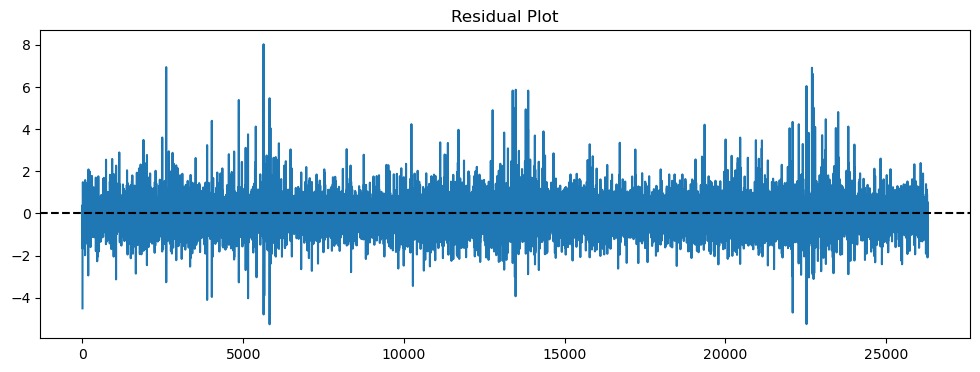

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(result.predict().values - df_train['temp'].values)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot')
plt.show()

## 予測

In [5]:
# testデータの読み込み
df_test = pd.read_csv(os.path.join(os.getcwd(),'data',f'temperature-{END_YEAR+1}.csv'), encoding='shift-jis', skiprows=3)
df_test.columns = ['datetime', 'temp']
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.index = pd.DatetimeIndex(df_test['datetime']).to_period('H')
df_test = df_test[['temp']]
df_test.head()

,temp
datetime,
2023-01-01 01:00,2.7
2023-01-01 02:00,2.9
2023-01-01 03:00,3.5
2023-01-01 04:00,3.1
2023-01-01 05:00,3.4


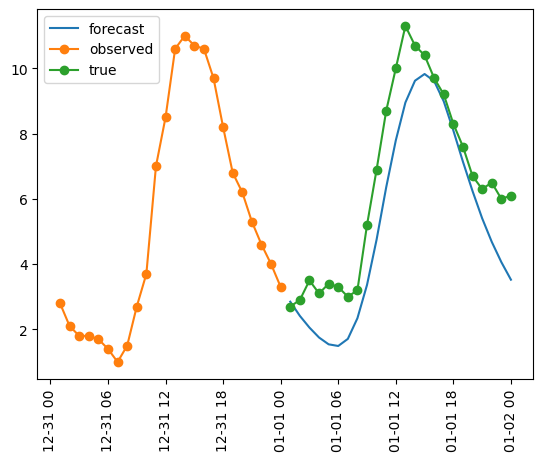

In [8]:
forecast = result.forecast(steps=order[0])
observed = df_train['temp'].tail(order[0])
true = df_test['temp'].head(order[0])

plt.plot(forecast.index.to_timestamp(), forecast.values, label='forecast')
plt.plot(observed.index.to_timestamp(), observed.values, label='observed', marker='o')
plt.plot(true.index.to_timestamp(), true.values, label='true', marker='o')
plt.xticks(rotation=90)
plt.legend()
plt.show()

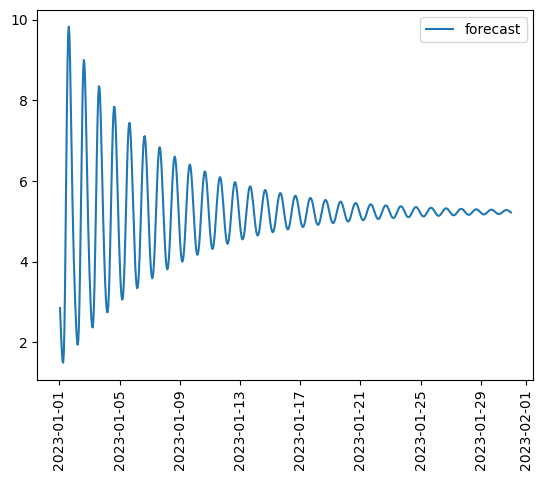

In [9]:
forecast = result.forecast(steps=24*30)

plt.plot(forecast.index.to_timestamp(), forecast.values, label='forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()